# Functional analysis of relevant RBPs

In [1]:
library(ggplot2)
library(dplyr)
library(data.table)
library(furrr)
library(purrr)
library(dplyr)
library(ggVennDiagram)
library(ggplot2)
library(ggsci)
library(fgsea)
library(ComplexHeatmap)
library(matrixStats)
library(ggpubr)
library(msigdbr)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: future


Attaching package: ‘purrr’


The following object is masked from ‘package:data.table’:

    transpose


Loading required package: grid

ComplexHeatmap version 2.8.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with ze

### Functions

In [2]:
# GORA analysis function
fora_test<-function(d,...){
    
    event.genes <- unique(d$gene_id) 
    event <- unique(d$event_type)
    event.universe<-gene_universe$gene_id[gene_universe$event_type==event]
    
    res<-fora(pathways = hm_list,
              genes = event.genes,
              universe = event.universe,
              minSize = 3, 
              maxSize = 250) %>%
        filter(overlap!=0) %>%
        mutate(n_spl_genes=length(event.genes))
    
    return(res)
    
}

### Inputs

In [3]:
# Params
analysis<-"condition"  # Analysis type tag (condition / TumorStageContinuous)
voi<-"conditiontumor"  # Variable of interest (conditiontumor / sex / age / stage)
events_used<-c("SE","RI","AF","AL","A5","A3") # Events to include in the analysis
n<-11 # number of cancers for calling shared events
p.signif.pathway<-0.2 # FDR cutoff on the significance of overrepresentation tests
set.seed(7)
cancer_order_set<-c("SKCM","UVM","SARC","LAML","TGCT","UCEC","CESC","PRAD","READ","BLCA",
                    "COAD","PAAD","CHOL","KIRP","KIRC","KICH","ACC","PCPG","STAD","LIHC",
                    "MESO","LUSC","LUAD","BRCA","THCA","ESCA","HNSC")

# Inputs
obj_dir<-"../input/objects"
flags_file<-paste0(obj_dir,"/tcga.",analysis,".psi.flags.RDS")

# RBP info
aff_dir<-"../../chapter2_Methods/2.5_ASregulators/output/affimx"
rbp_obj_file<-"../output/objects/Figure10_rbp_motif_coefs_gex_sig.RDS"
cors_file<-"../output/data/RBP_significant_correlations.tsv"
rbp_info_file<-"../input/references/cisbp_Homo_sapiens_2023_06_RBP_Information_all_motifs.txt"
motif_clusters_file<-"../input/data/25112023_representative_cluster_motifs.tsv"
mtargets_file<-"../output/objects/Figure10_all_motif_targets.RDS"

# Internal
vars<-c(voi,"impurity")
res_file<-paste0("../input/objects/tcga.",analysis,".res.lfcShrink.RDS")
fig_dir<-paste0("../output/figures/functional_validations")
dir.create(fig_dir, showWarnings = FALSE)

In [4]:
plan(multisession, workers = 6)

### Load data

In [6]:
motif_targets_genes <- readRDS(file = mtargets_file)
trex.res.lfsh <- readRDS(file = res_file) 
gora <- readRDS(paste0(obj_dir,"/gora.",analysis,".",n,".cancers.RDS"))
rbp_motif_coefs_gex_sig <- readRDS(rbp_obj_file)

In [7]:
motif_clusters <- data.table::fread(motif_clusters_file,sep="\t") %>%
                  rename("Motif_ID"="motif")
rbp_info <- fread(rbp_info_file,head = TRUE,sep = "\t",data.table = FALSE)

In [8]:
flags<-readRDS(flags_file)

### Process RBP-motif pairs

In [9]:
rbp_motif <- rbp_info %>%
             select('Motif_ID',"ENSDBID",'RBP_Name','Family_Name') %>%
             rename("GENEID"="ENSDBID") %>%
             inner_join(.,motif_clusters ) %>%
             group_by(representative_motif) %>%
             mutate(RBPs=paste(unique(RBP_Name),collapse = ", "))

Joining, by = "Motif_ID"


In [10]:
rbp_mcg <- rbp_motif_coefs_gex_sig %>%
           mutate(RBP_Name=sub("_.*","",GENENAME)) %>%
           group_by(representative_motif) %>%
           mutate(RBPs=paste(unique(RBP_Name),collapse = ", ")) %>%
           select(-Motif_ID,-GENENAME) %>%
           distinct()

In [11]:
mtf_tgs <- motif_targets_genes %>%
           rename("RBP_Name"="RBP_GENENAME") %>%
           ungroup() %>%
           inner_join(.,rbp_motif) %>%
           distinct() %>%
           mutate(target_gene_region=ifelse(zscore_padj<0.2,"target","other"))

Joining, by = c("representative_motif", "Motif_ID", "RBP_Name")


In [12]:
valid_events<-flags %>%
                group_by(event_type,event_id) 

In [13]:
tgenes<-motif_targets_genes  %>%
        filter(target_gene_region=="target") %>%
        distinct(gene_id)

In [14]:
saveRDS(mtf_tgs,file="../output/objects/Figure10_motif_targets.RDS")

### Define gene universe

Out of all the genes that can undergo a given form of splicing, which pathways are enriched in the RBFOX targets that are differentially spliced in tumors 

will test in a background of genes that are:
- flagged as valid  
- targets of at least one RBP  

Analysis is done stratifying by:
- event type

Testing is done per event type at the gene level. Thus if a gene has at least one event of that type passing the fltering criteria the gene will be included in the analysis. If a gene has events that have positive and events that have negative lfc values, the gene will appear in both categories.

The foreground gene groups are obtained by:
1. Events that are significant in an least one cancer type
2. Correlation between the dlogitPSI of each event with the LFC of each RBP across all cancer types. 
3. Select events that have the same correlation direction as that of the correlation between the RBP expression and the differntial binding
Then do GORA on each test separately

In [15]:
trex.res.lfsh <- trex.res.lfsh %>%
                    filter(!is.na(padj),exp_var=="conditiontumor") %>%
                    inner_join(.,valid_events) %>%
                    mutate(gene_id=sub("\\.\\d+","",gene_id)) 
trex.res <- trex.res.lfsh %>% 
            filter(gene_id%in%tgenes$gene_id) %>%
            group_by(event_id) %>%
            mutate(nc_sig=sum(padj<0.05)) %>% 
            filter(nc_sig>=1)%>%
            ungroup()
dim(trex.res)
dim(trex.res.lfsh)

Joining, by = c("event_type", "cancer", "event_id")


[1] 546561     24

[1] 3108225      23

In [16]:
gene_universe <- trex.res.lfsh %>%
                 mutate(gene_id=sub("\\.\\d+","",gene_id)) %>%
                 distinct(event_type,gene_id) %>%
                 group_by(event_type) 

In [17]:
saveRDS(gene_universe,file="../output/objects/Figure10_gene_universe_targets.RDS")

## GORA on RBP targets
---

### Categorize RBP targets

Test only RBPs that have at least 3 target genes and select cancer types in which their binding coefficients are significant

In [18]:
rbp_fgd<-rbp_motif_coefs_gex_sig %>% 
         filter(cor.padj<0.1) %>% # RBPs with significant correlation between LFC and diff binding 
         distinct(cancer,event_type,representative_motif,RBP_Name,position,direction,cor.estimate,log2FoldChange,cor.padj) %>%
         arrange(RBP_Name)
length(unique(rbp_fgd$RBP_Name))

[1] 97

Collapse estimates into gene dLogitPSI by taking the dLogitPSI of the event with the smallest pvalue

In [19]:
trex_fgd <- trex.res %>%
            rename("dLogitPSI"="log2FoldChange",
                  "trex_pvalue"="pvalue") %>%
            distinct(event_id,event_type,gene_id,cancer,dLogitPSI,trex_pvalue) %>%
            left_join(.,rbp_fgd) 

Joining, by = c("event_type", "cancer")


Calculate the correlation between dLogit PSI and LFC of each RBP across all cancers

In [20]:
trex_fgd_cors_ev <- trex_fgd %>%
                    group_by(event_type,gene_id,event_id,position,direction,representative_motif,RBP_Name) %>%
                    mutate(n=length(cancer)) %>%
                    filter(sd(dLogitPSI)!=0,
                           sd(log2FoldChange)!=0,
                           n>=3) %>%
                    summarize(ncancers=length(unique(cancer)),
                              cors=list(cor.test(dLogitPSI,log2FoldChange)[c("estimate","p.value")]))  %>%
                    rowwise() %>%
                    mutate(cor.das=cors[[1]][1],
                           cor.das.pvalue=cors[[2]][1]) %>%
                    as_tibble() %>%
                    select(-cors) %>%
                    group_by(event_type) %>%
                    mutate(cor.das.padj=p.adjust(cor.das.pvalue,method="fdr")) %>%
                    left_join(.,
                              rbp_fgd %>%
                                 distinct(event_type,representative_motif,position,direction,RBP_Name,cor.estimate)) %>%
                    mutate(cor.das.gp=ifelse(cor.das > 0,"pos","neg"),
                           cor.dbd.gp=ifelse(cor.estimate > 0,"pos","neg")) 

`summarise()` has grouped output by 'event_type', 'gene_id', 'event_id',
'position', 'direction', 'representative_motif'. You can override using the
`.groups` argument.
Joining, by = c("event_type", "position", "direction", "representative_motif",
"RBP_Name")


Intersect with RBP affinity targets genes

In [21]:
mtf_target_set <- mtf_tgs %>%
                    filter(target_gene_region=="target") %>%
                    mutate(position=sub("_.*","",seq_id),
                           direction=sub("[SE]\\d+_","",seq_id) %>% sub("_.*","",.)) %>%
                    distinct(event_type,position,direction,gene_id,representative_motif,RBP_Name) 

Group all events of the same gene with the same behavior 

In [22]:
trex_fgd_cors <- trex_fgd_cors_ev %>%
                    group_by(event_type,position,direction,gene_id,representative_motif,RBP_Name,cor.das.gp,cor.dbd.gp) %>%
                    summarize(event_id_list=list(event_id),
                              ncancers_list=list(ncancers),
                              ncancers=mean(ncancers),
                              nevents=length(unique(event_id)))

`summarise()` has grouped output by 'event_type', 'position', 'direction',
'gene_id', 'representative_motif', 'RBP_Name', 'cor.das.gp'. You can override
using the `.groups` argument.


In [23]:
targets<-inner_join(trex_fgd_cors %>% ungroup(),
                    mtf_target_set %>% ungroup()) %>%
         mutate(behavior=ifelse(cor.das.gp==cor.dbd.gp,"similar","opposite"))

Joining, by = c("event_type", "position", "direction", "gene_id",
"representative_motif", "RBP_Name")


### Define gene sets

In [24]:
# Hallmark pathways
hm_gene_sets <- msigdbr(species = "human",category="H") 
hm_df <- hm_gene_sets %>% 
         distinct(gs_cat,gs_name,ensembl_gene) %>%
         as.data.frame() 
hm_list <- split(x = hm_df$ensembl_gene, f = hm_df$gs_name)

In [25]:
rbps<-unique(targets$RBP_Name)
message("Analyzing ",length(rbps)," RBPs")

Analyzing 58 RBPs



#### Define gene groupings

- Do the groups based on the sign of the correlation with each region, and then use only events that behave as expected (same sign) to the RBP in that cancer type
- Only consider the cancer types in which the sign of the regression coefficient is consistent

- calculate the correlation between RBP lfc and event logit PSI across all cancer types, select events that have a correlation of the same sign as the one from the correlation between RBP lfc and differential binding 
- test using the same universe now 

#### Run tests

In [26]:
# Run tests
targets_gora<-targets %>%
              mutate(grouptag = paste(RBP_Name,position,direction,event_type,cor.das.gp,cor.dbd.gp,sep="_")) %>%
              select(event_type,gene_id,grouptag) %>%
              group_by(grouptag) %>%
              tidyr::nest(data = c(event_type:gene_id)) %>%
              mutate(gora_res = lapply(data,fora_test)) 

# Extract enriched pathways
targets_res <- targets_gora %>%
                ungroup() %>%
                mutate(npaths = unlist(lapply(gora_res,nrow))) %>%
                distinct(grouptag,gora_res) %>% 
                group_by(grouptag) %>%
                tidyr::unnest(gora_res) %>%
                arrange(desc(overlap))

In [27]:
saveRDS(targets_gora,"../output/objects/Figure10_targets_gora.RDS")
saveRDS(targets_res,"../output/objects/Figure10_targets_res.RDS")

### Visualizations

In [28]:
ss_levels<-list("SE" = c("E1","S2","E2","S3"),
                "MX" = c("E1","S2","E2","S3","E3","S4"),
                "A5" = c("E1","E2","S3"),
                "A3" = c("E1","S2","S3"),
                "RI" = c("S1","E1","S2","E2"),
                "AF" = c("S1","E1","S2","E2","S3"),
                "AL" = c("E1","S2","E2","S3","E3"))

In [29]:
ss_levels_all<-lapply(names(ss_levels),function(name,...){
    s<-ss_levels[[name]]
    lapply(s,function(si,...){
            paste(name,si,c("UP","DOWN"))
    })
})%>%unlist(.,recursive = T)

In [30]:
targets_gora<-readRDS("../output/objects/Figure10_targets_gora.RDS")
targets_res<-readRDS("../output/objects/Figure10_targets_res.RDS")

In [31]:
sp<-targets_res %>%
    arrange(desc(overlap)) %>%
    mutate(tags = list(strsplit(grouptag,"_") %>% unlist() )) %>%
    rowwise() %>%
    mutate(RBP_Name = unlist(tags)[1],
           position = unlist(tags)[2],
           direction = unlist(tags)[3],
           event_type = unlist(tags)[4],
           das.gp = unlist(tags)[5],
           dbd.gp = unlist(tags)[6]) %>%
    select(-tags)

In [32]:
datasets<-list()
for(event in unique(sp$event_type)){
    sp.event <- sp %>% 
                filter(event_type==event) %>%
                ungroup() %>%
                as_tibble() %>%
                mutate(position=factor(position,ss_levels[[event]]),
                       direction=factor(direction,levels=c("UP","DOWN")),
                       signif=padj<0.2) %>%
                mutate(behavior= ifelse(das.gp==dbd.gp,"similar","opposite")) %>%
                mutate(pathway=sub("HALLMARK_","",pathway) %>% gsub("_"," ",.))

    pord<-sp.event%>%
          group_by(pathway) %>%
          summarize(nsig=sum(signif)) %>%
          #filter(nsig!=0) %>%
          arrange(nsig)
    rord<-sp.event%>%
          group_by(RBP_Name) %>%
          summarize(nsig=sum(signif)) %>%
          filter(nsig!=0) %>%
          arrange(nsig)
    reg<-sp.event%>%
          group_by(position,direction) %>%
          summarize(nsig=sum(signif)) %>%
          filter(nsig!=0) %>%
          arrange(nsig) %>%
          mutate(region=paste(position,direction))
    pdata<-sp.event %>%
            filter(pathway %in% pord$pathway,
                   RBP_Name %in% rord$RBP_Name) %>%
            mutate(pathway =factor(pathway,levels=pord$pathway),
                   region = paste(position,direction),
                   behavior = factor(behavior,levels=c("similar","opposite"))) %>%
            filter(region %in% reg$region)
    
    datasets[[event]]<-pdata
}

`summarise()` has grouped output by 'position'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'position'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'position'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'position'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'position'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'position'. You can override using the
`.groups` argument.


In [33]:
pdata<-do.call(rbind,datasets)
eord<-pdata %>%
      group_by(event_type) %>%
      summarize(nsig=sum(padj<0.2))%>%
      arrange(desc(nsig))
pord<-pdata%>%
      group_by(pathway) %>%
      summarize(nsig=sum(signif),n=overlap) %>%
      filter(nsig!=0) %>%
      slice_max(nsig*n,n=1,with_ties = F) %>%
      arrange(desc(nsig*n))
rord<-pdata%>%
      group_by(RBP_Name) %>%
      summarize(nsig=sum(signif)) %>%
      filter(nsig!=0) %>%
      arrange(desc(nsig))

pdata<-pdata %>%
       filter(pathway %in% pord$pathway,
              RBP_Name %in% rord$RBP_Name) %>%
       mutate(event_type=factor(event_type,levels=eord$event_type),
              pathway = factor(pathway,levels=pord$pathway),
              RBP_Name = factor(RBP_Name,levels =rord$RBP_Name)) %>%
       mutate(location = factor(paste(event_type,position,direction),levels=ss_levels_all))

`summarise()` has grouped output by 'pathway'. You can override using the
`.groups` argument.


In [34]:
pdata<-pdata %>%
       filter(event_type%in%c("SE","RI","AL","A3","A5"))

rbp_fgd_sig05<-rbp_fgd %>%
                mutate(sig_in_a=cor.padj<0.05) %>%
                ungroup() %>%
                distinct(RBP_Name, position, direction, event_type, sig_in_a, cor.estimate)
pdata2<-pdata %>%
        left_join(.,rbp_fgd_sig05) %>%
        filter(sig_in_a)

Joining, by = c("RBP_Name", "position", "direction", "event_type")


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


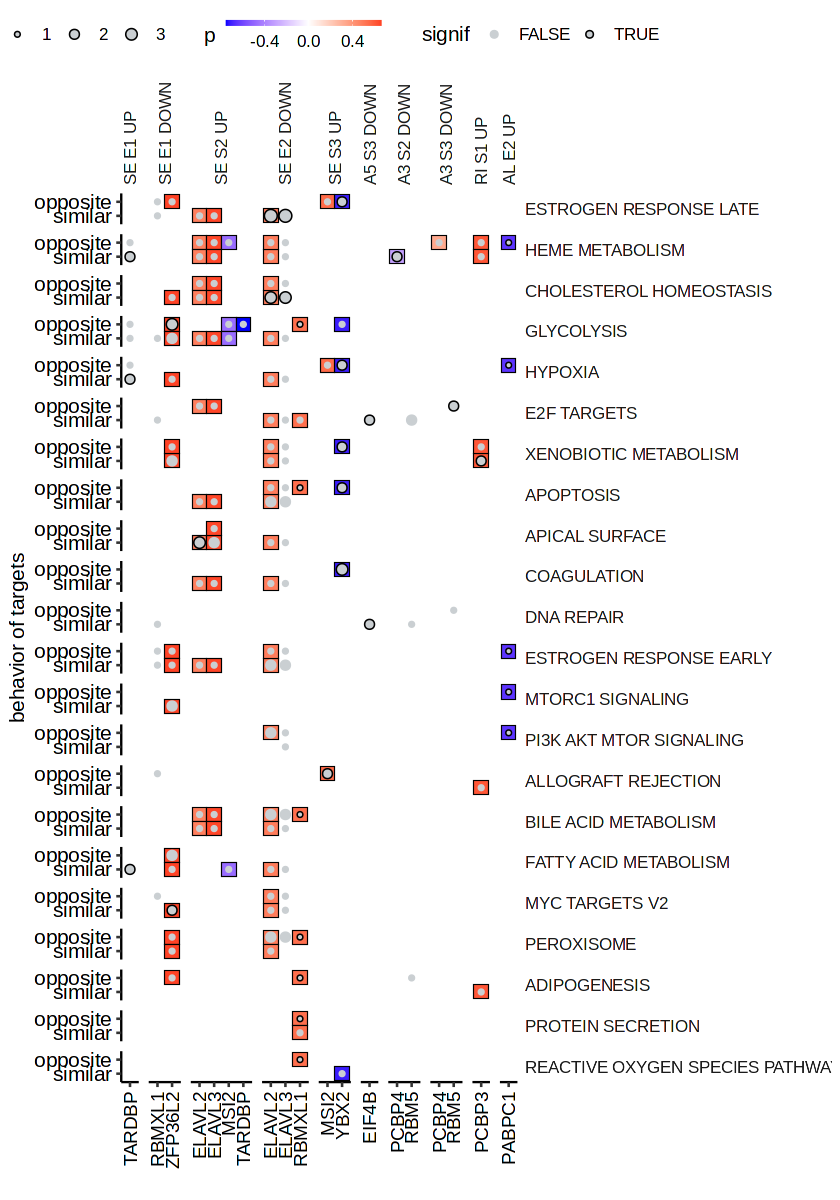

In [35]:
options(repr.plot.height = 10,repr.plot.width=7)
g<-pdata %>%
   ggplot(.,aes(x=RBP_Name,y=behavior))+
         geom_tile(data = pdata2,aes(fill=cor.estimate),color="black",lwd=0.25)+
         scale_fill_gradient2(low = "blue",mid = "white",high = "red",
                                guide = guide_colourbar(direction = "horizontal", 
                                                             barheight = 0.25,
                                                             barwidth = 6.5,
                                                             title.hjust = 0.5,
                                                             label.position = "bottom"))+
        geom_point(pch=21,aes(size=overlap,color=signif),fill="#CACFD2")+
        theme_pubr()+
        scale_color_manual(values=c("#CACFD2","black"))+
        facet_grid(~pathway~location,scales="free_x",space="free")+
        theme(axis.text.x=element_text(angle=90,hjust=1,vjust=0.5,size=11),
              axis.text.y=element_text(vjust=0.5),
              strip.background = element_blank(),
              strip.text.x = element_text(angle = 90,hjust=0,vjust=0.5),
              strip.text.y = element_text(angle = 0,hjust=0))+
        scale_size(range=c(1,3),breaks = 1:3)+
        labs(x="",y="behavior of targets",size="n",fill="p")

fileout<-paste0(fig_dir,"/",analysis,"_gora_cross_cancers.pdf")
ggsave(g,filename = fileout,
       width = 7,height = 10,device = cairo_pdf)
g